In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

In [4]:
df = pd.read_csv('/content/drive/MyDrive/PhD/Linear regression/training_data.csv')
df

,word,speaker,emotion,time,position,target sentence,speaker gender,length,surprisal GPT,surprisal BERT,log probability,baseline,gpt model,bert model,fold
0,imamo,1,0,0.6,b,25,f,5.0,19.857792,3.380102,-6.051349,0.392622,0.382158,0.408092,2
1,još,1,0,0.1,m,25,f,3.0,31.651057,0.000163,-7.325636,0.290491,0.307289,0.279860,2
2,četiri,1,0,0.2,e,25,f,6.0,50.446848,0.000199,-8.268886,0.474789,0.498755,0.447117,2
3,minuta,1,0,0.8,e,25,f,6.0,22.568617,0.000554,-9.569658,0.488960,0.474685,0.461784,2
4,vremena do,1,0,0.3,e,25,f,9.0,32.872915,0.000472,-13.097782,0.701420,0.681710,0.658176,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75781,kontaktu,1052,4,0.8,e,35,m,8.0,50.682962,0.004991,-9.965021,0.605126,0.605304,0.560764,0
75782,više,1052,4,0.4,e,35,m,4.0,33.920975,0.001764,-6.613154,0.347075,0.347292,0.330350,0
75783,od,1052,4,0.2,e,35,m,2.0,12.859425,0.000015,-4.716686,0.215884,0.215859,0.213031,0
75784,godinu,1052,4,0.5,e,35,m,6.0,17.708307,0.000175,-4.755203,0.441396,0.441102,0.411702,0


In [5]:
def inf_k_model(df, k, surprisal):

    surprisal_name = surprisal + ' ' + str(k)
    model_name = surprisal_name + ' model'
    df[surprisal_name] = df[surprisal] ** k
    results_df = pd.DataFrame(columns = df.columns.tolist().append(model_name))

    for fold in df['fold'].unique():

        test_data = df[df['fold'] == fold]
        y_test = df[df['fold'] == fold][['time']]

        train_data = df[df['fold'] != fold]
        y_train = df[df['fold'] != fold][['time']]

        model = LinearRegression()
        model.fit(train_data[['length', 'log probability', surprisal_name]], y_train)

        y_pred = model.predict(test_data[['length', 'log probability', surprisal_name]])

        test_data.loc[:, model_name] = y_pred
        # Concatenate the DataFrames along rows (axis=0)
        results_df = pd.concat([results_df, test_data], axis=0)
    return results_df

In [6]:
def calculate_log_Likelihood(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    return norm.logpdf(data, loc=mean, scale=std_dev)

# Calculate AIC for models with different numbers of parameters
def calculate_aic(real_values, results, k):
    residuals = np.array(real_values) - np.array(results)
    log_likelihood = calculate_log_Likelihood(residuals)
    aic = 2 * k - 2 * log_likelihood
    return aic, np.mean(log_likelihood), np.std(log_likelihood)

def akaike_for_column(column_name, model_name, baseline_model = 'baseline'):
    difference = []

    for gender in df[column_name].unique():

        data = df[df[column_name]==gender]

        _, mean_ll_1, std_ll_1 = calculate_aic(data['time'], data[baseline_model], 2)
        _, mean_ll_2, std_ll_2 = calculate_aic(data['time'], data[model_name], 3)
        difference.append(mean_ll_1-mean_ll_2)

    return difference, std_ll_2

In [7]:
import warnings

# Filter out SettingWithCopyWarning
warnings.filterwarnings("ignore")
surprisal_gpt = 'surprisal GPT'
surprisal_bert = 'surprisal BERT'
x_axis = np.arange(0.25, 3, 0.25)

for i in x_axis:
  k = round(i, 2)
  df = inf_k_model(df, k, surprisal_gpt)
  df = inf_k_model(df, k, surprisal_bert)

# Reset warnings to default behavior (optional)
warnings.resetwarnings()

In [8]:
def calculate_delta_ll(surprisal, k, emotion_data, std_data):

    try:
      delta_ll,std_list = akaike_for_column('emotion', surprisal + ' ' + str(k) + ' model', 'baseline')
    except:
      print(f"{surprisal} at k = {k}")
      delta_ll = [0,0,0,0,0]
      std_list = [1,1,1,1,1]
    for emotion in range(0,5):
      emotion_data[emotion].append(delta_ll[emotion])
      std_data[emotion].append(std_list)

    return

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
# Initialize an empty dictionary to store emotion-wise data
emotion_data_gpt = { 0: [], 1: [], 2: [], 3: [], 4: []}
gpt_std = { 0: [], 1: [], 2: [], 3: [], 4: []}
emotion_data_bert = { 0: [], 1: [], 2: [], 3: [], 4: []}
bert_std = { 0: [], 1: [], 2: [], 3: [], 4: []}

for i in x_axis:
    k = round(i, 2)
    calculate_delta_ll(surprisal_gpt, k, emotion_data_gpt, gpt_std)
    calculate_delta_ll(surprisal_bert, k, emotion_data_bert, bert_std)

In [1]:
def plot_data(emotion, emotion_data, std_data, plt_number, c):

  # Plot results for BERT model
  plt.subplot(2, 5, plt_number)

  y_axis = np.array(emotion_data[emotion])
  y_std = np.array(std_data[emotion]) * 0.001
  y_std = np.std(y_axis)

  # Find the index of the maximum peak
  max_peak_index = np.argmax(y_axis)
  max_peak_x = x_axis[max_peak_index]

  # Adjust the size of the dots based on the standard deviation of y_axis
  dot_size = 100
  # Plot the scatter plot
  scatter = plt.scatter(x_axis, y_axis, s=dot_size, color=c)

  # Add shadows based on the standard deviation of y_axis
  shadow_c = c[:-1] + (0.3,)
  plt.fill_between(x_axis, y_axis + y_std, y_axis - y_std, color=shadow_c, label='Shadow')
  # Add a vertical line at the position of the maximum peak
  #plt.axvline(x=max_peak_x, color=c, linestyle='--', label='Max Peak')

  plt.grid()
  plt.title(emotion_names[emotion])
  # Set x-axis ticks more frequently
  plt.xticks(np.linspace(0.25, 2.5, 4))  # Adjust the parameters as needed

  return

Text(0.04, 0.5, '$\\Delta$LogLikelihood')

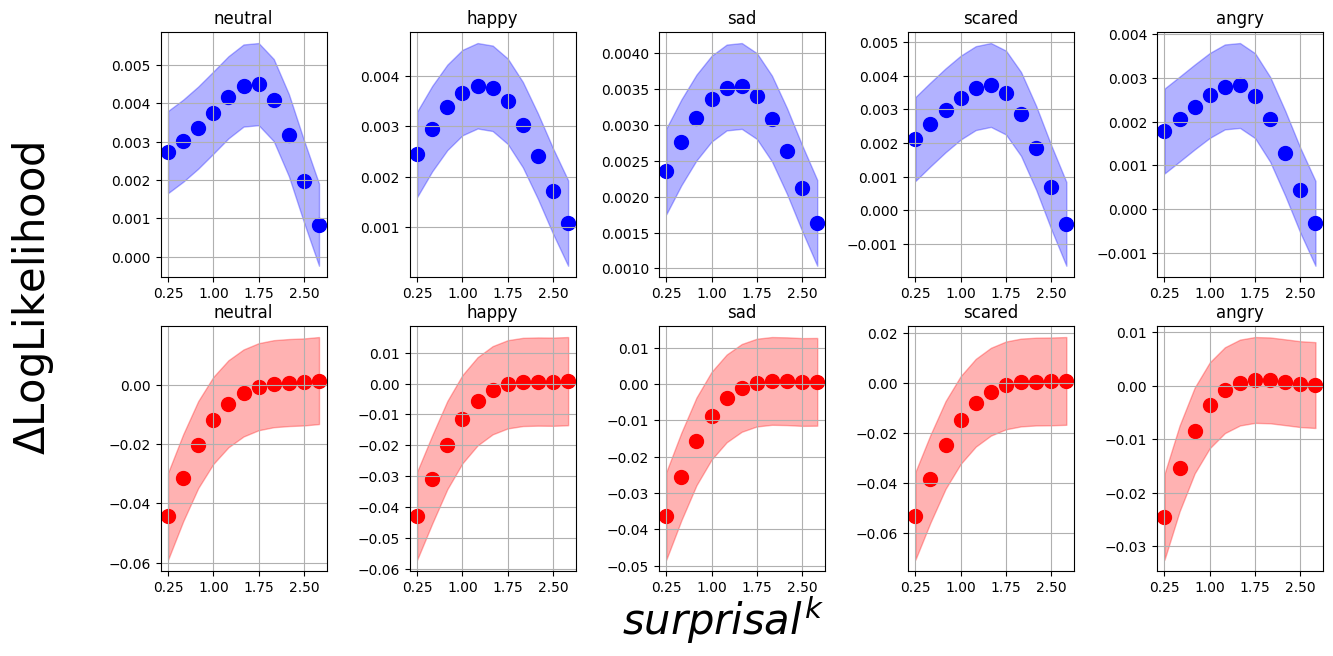

In [17]:
import matplotlib.patches as patches

fig = plt.figure(figsize=(15,7))
emotion_names = ['neutral', 'happy', 'sad', 'scared', 'angry']

for emotion in range(0,5):
  plt.subplot(2, 5, emotion + 1)
  plot_data(emotion, emotion_data_gpt, gpt_std, emotion + 1, (0, 0, 1, 1))
  plot_data(emotion, emotion_data_bert, bert_std, emotion + 6, (1, 0 , 0, 1))

# Adjust the layout to prevent overlapping labels
plt.subplots_adjust(wspace=0.5)  # Adjust the spacing as needed
# Add a common x-axis label
fig.text(0.5, 0.04, '$surprisal^k$', ha='center', va='center', fontsize=30)
# Add a common y-axis label
fig.text(0.04, 0.5, r'$\Delta$LogLikelihood', ha='center', va='center', rotation='vertical', fontsize=30)
